In [421]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from pathlib import Path

In [422]:
root_path = "/media/Datacenter_storage/PublicDatasets/cerebral_microbleeds_MAYO/mayo_t2s_png"
task = "test"

### Dataset Visualization

In [423]:
# /images/train/sub-233_slice_041.png
img_num = "5929128"
slice_num = "22"

In [424]:
def visualize_prediction_overlay(root_path, img_num, slice_num, prediction_dir, darken_factor=0.8):
    """
    Visualize original image with prediction overlay and darkened background
    """
    # Build paths
    image_path = f"{root_path}/images/{task}/{img_num}_{slice_num}.png"
    prediction_path = f"{prediction_dir}/{img_num}_{slice_num}.png"
    
    # Check if files exist
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    if not os.path.exists(prediction_path):
        print(f"Prediction mask not found: {prediction_path}")
        return
    
    # Load original image
    original_image = np.array(Image.open(image_path))
    
    # Create overlay with darkened background
    overlay, mask_binary = overlay_prediction_mask(image_path, prediction_path, 
                                                  alpha=0.3, mask_color='red', 
                                                  darken_factor=darken_factor)
    
    # Load prediction mask for display
    pred_mask = np.array(Image.open(prediction_path).convert('L'))
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # # Original image
    # if len(original_image.shape) == 2:
    #     axes[0].imshow(original_image, cmap='gray')
    # else:
    #     axes[0].imshow(original_image)
    # axes[0].set_title(f'Original: {img_num}_{slice_num}')
    # axes[0].axis('off')
    
    # Prediction mask
    axes[0].imshow(pred_mask, cmap='gray')
    axes[0].set_title('Prediction Mask')
    axes[0].axis('off')
    
    # Overlay with darkened background
    axes[1].imshow(overlay)
    axes[1].set_title(f'Prediction Overlay (Darkened {darken_factor})')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    total_pixels = pred_mask.shape[0] * pred_mask.shape[1]
    predicted_pixels = np.sum(mask_binary)
    print(f"Predicted pixels: {predicted_pixels} / {total_pixels} ({predicted_pixels/total_pixels*100:.2f}%)")

In [425]:
def overlay_prediction_mask(image_path, prediction_mask_path, alpha=0.4, mask_color='red', darken_factor=0.2):
    """
    Overlay prediction mask on original image with transparency and darkened background
    """
    # Load original image and prediction mask
    image = Image.open(image_path)
    image = np.array(image)
    
    pred_mask = Image.open(prediction_mask_path).convert('L')
    pred_mask = np.array(pred_mask)
    
    # Handle grayscale images (convert to 3-channel if needed)
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    
    # Create darkened version of the original image
    darkened_image = (image * darken_factor).astype(np.uint8)
    
    # Create colored overlay starting with darkened image
    overlay = darkened_image.copy()
    
    # Define colors
    colors = {
        'red': [255, 0, 0],
        'green': [0, 255, 0],
        'blue': [0, 0, 255],
        'yellow': [255, 255, 0],
        'cyan': [0, 255, 255],
        'magenta': [255, 0, 255]
    }
    
    # Create binary mask (assuming white pixels are predictions)
    mask_binary = pred_mask > 128
    
    # Apply colored overlay where mask is positive (on darkened background)
    if np.any(mask_binary):
        overlay[mask_binary] = (alpha * np.array(colors[mask_color]) + 
                               (1 - alpha) * darkened_image[mask_binary]).astype(np.uint8)
    
    return overlay, mask_binary

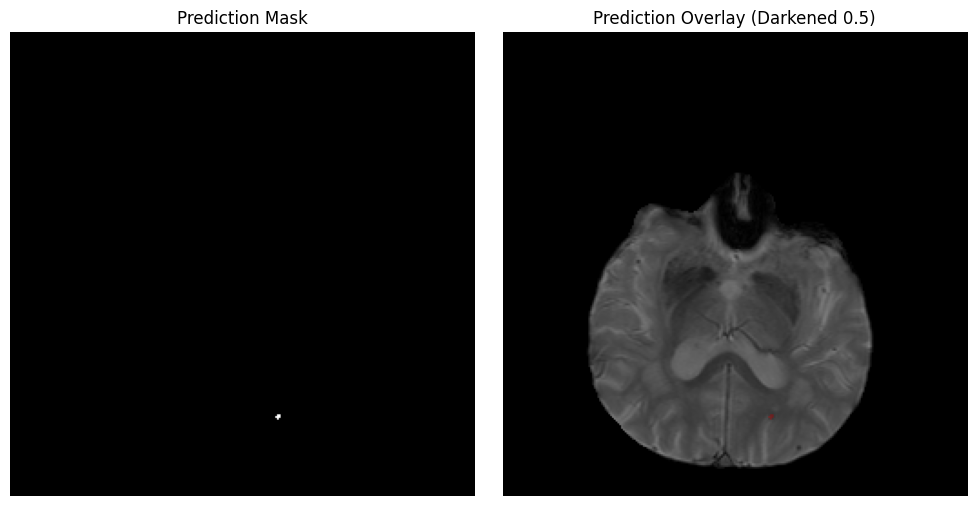

Predicted pixels: 6 / 65536 (0.01%)


In [426]:
# prediction_path = f"/media/Datacenter_storage/Ji/MedSAM/overall_eval/"
prediction_path = f"/media/Datacenter_storage/Ji/MedSAM/overall_eval_MAYO/"

visualize_prediction_overlay(root_path, img_num, slice_num, prediction_path, darken_factor=0.5)

### Ground Truth Box

In [427]:
def plot_original_image(img_path):    
    img = Image.open(img_path)
    img = np.array(img)
    
    print(img.shape)
    plt.figure(figsize=(10, 10))

    plt.imshow(img[:,:], cmap='gray')
    plt.title('T1 Original Image')

In [428]:
def extract_patch(channel, center_x, center_y, patch_size):
    """
    Extract a fixed-size patch centered on the given coordinates
    """
    height, width = channel.shape
    half_size = patch_size // 2
    
    # Calculate patch boundaries
    x_min = int(center_x - half_size)
    y_min = int(center_y - half_size)
    x_max = int(center_x + half_size)
    y_max = int(center_y + half_size)
    
    # Handle edge cases
    if x_min < 0:
        x_max -= x_min  # Shift patch right
        x_min = 0
    if y_min < 0:
        y_max -= y_min  # Shift patch down
        y_min = 0
    if x_max > width:
        x_min -= (x_max - width)  # Shift patch left
        x_max = width
    if y_max > height:
        y_min -= (y_max - height)  # Shift patch up
        y_max = height
    
    return channel[y_min:y_max, x_min:x_max]

def plot_yolo_boxes_with_channel_patches(image_path, bboxes):
    """
    Plot original channels and their 16x16 patches without overlap
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file does not exist: {image_path}")
    
    try:
        image = Image.open(image_path)
        image = np.array(image)
    except Exception as e:
        raise IOError(f"Error reading the image: {e}")
    
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    height, width = image.shape[:2]
    n_boxes = len(bboxes)
    
    if n_boxes == 0:
        print("No bounding boxes found in the image.")
        return
        
    # Create figure with original image row plus one row per bbox
    # fig = plt.figure(figsize=(15, 4 * (n_boxes + 1)))
    fig = plt.figure(figsize=(15, 10))

    # Create GridSpec with n_boxes + 1 rows (1 for original images, rest for patches)
    gs = plt.GridSpec(n_boxes + 1, 3, figure=fig, hspace=0.4)

    # Channel names
    # channel_names = ['T1', 'T2', 'T2S']
    channel_names = ['T2S Ground Truth']

    # Plot each channel
    for channel_idx, channel_name in enumerate(channel_names):
        # Extract channel
        channel = image[:, :, channel_idx]

        # Plot full image in top row
        ax = fig.add_subplot(gs[0, channel_idx])
        # im = ax.imshow(channel, cmap='gray', vmin=0, vmax=255)
        im = ax.imshow(channel, cmap='gray')
        # ax.set_title(f'{channel_name}')
        ax.axis('off')
        # plt.colorbar(im, ax=ax, label='Intensity')
        
        # Draw all bounding boxes on original image
        for bbox in bboxes:
            class_id, x_center, y_center, gt_width, gt_height = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            patch_size = gt_width * width
            
            # Draw fixed-size box
            half_size = patch_size // 2
            x_min = center_x - half_size
            y_min = center_y - half_size
            if class_id == 0.0:
                rect = plt.Rectangle((x_min, y_min), patch_size, patch_size,
                               linewidth=0.3, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
            elif class_id == 1.0:
                rect = plt.Rectangle((x_min, y_min), patch_size, patch_size,
                               linewidth=0.3, edgecolor='blue', facecolor='none')
                ax.add_patch(rect)
            
        
        # # Plot patches
        # for box_idx, bbox in enumerate(bboxes):
        #     _, x_center, y_center, gt_width, gt_height = bbox
        #     center_x = int(x_center * width)
        #     center_y = int(y_center * height)
            
        #     # Extract patch
        #     patch_size = gt_width * width
        #     patch = extract_patch(channel, center_x, center_y, patch_size)
        #     # Create subplot for patch in its own row
        #     ax_patch = fig.add_subplot(gs[channel_idx, box_idx + 1])
        #     # im_patch = ax_patch.imshow(patch, cmap='gray', vmin=0, vmax=255)
        #     im_patch = ax_patch.imshow(patch, cmap='gray')
        #     ax_patch.set_title(f'{channel_name} Patch {box_idx + 1}')
        #     # plt.colorbar(im_patch, ax=ax_patch, label='Intensity')
        #     ax_patch.axis('off')
    
    # plt.suptitle('Ground Truth', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

def visualize_image_channels_and_patches(root_path, img_num, slice_num):
    """
    Visualize MRI channels and their patches with fixed-size boxes
    """
    label_path = f"{root_path}/labels/{task}/{img_num}_{slice_num}.txt"
    image_path = label_path.replace("labels", "images").replace("txt", "png")

    # plot_original_image(image_path)
    
    try:
        with open(label_path, 'r') as txt_file:
            bboxes = [list(map(float, line.split())) for line in txt_file.readlines()]
        
        plot_yolo_boxes_with_channel_patches(image_path, bboxes)
        
    except Exception as e:
        print(f"An error occurred: {e}")
        try:
            with Image.open(image_path) as img:
                print(f"Image format: {img.format}")
                print(f"Image size: {img.size}")
                print(f"Image mode: {img.mode}")
        except Exception as e:
            print(f"Could not open the image for additional information: {e}")

/tmp/ipykernel_466430/3114287093.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


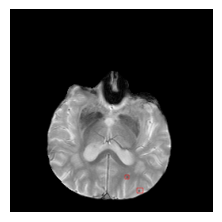

In [429]:
visualize_image_channels_and_patches(root_path, img_num, slice_num)

In [430]:
def find_nonempty_text_files(directory):
    nonempty_files = []
    dir_path = Path(directory)
    for txt_file in dir_path.glob("*.txt"):
        if txt_file.stat().st_size > 0:
            with open(txt_file, 'r') as f:
                content = f.read().strip()
                if content:  # Check if there's actual content after stripping whitespace
                    nonempty_files.append(txt_file.name)  
    return sorted(nonempty_files)  # Sort alphabetically

directory = f"{root_path}/labels/{task}"  # Replace with your folder path
nonempty_files = find_nonempty_text_files(directory)

count = 0
print(f"Found {len(nonempty_files)} non-empty text files:")
for filename in nonempty_files:
    count += 1
    print(f"- {filename}")
print(count)

Found 28 non-empty text files:
- 10745491_24.txt
- 10745491_28.txt
- 10745491_29.txt
- 10745491_30.txt
- 10745491_33.txt
- 10745491_34.txt
- 10745491_8.txt
- 12235430_16.txt
- 12235430_17.txt
- 4817777_29.txt
- 4817777_30.txt
- 4817777_31.txt
- 4906587_18.txt
- 4906587_19.txt
- 4918736_11.txt
- 4918736_12.txt
- 4918736_13.txt
- 4918736_24.txt
- 4918736_25.txt
- 4918736_26.txt
- 5808373_17.txt
- 5808373_18.txt
- 5929128_12.txt
- 5929128_21.txt
- 5929128_22.txt
- 5929128_25.txt
- 5929128_8.txt
- 6780698_27.txt
28
